In [38]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

# def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
#     ra1 = np.copy(ra)
#     dec1 = np.copy(dec)
#     ra1 = np.radians(ra1)
#     dec1 = np.radians(dec1)
#     alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
#     delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
#     sd = np.sin(delt0)
#     cd = np.cos(delt0)
#     d0 = 49.9
#     io = io*np.pi/180 #np.radians(io) #inclination #25.86
#     pa = (pa-90)*np.pi/180 #np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
#     cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
#     sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
#     sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
#     dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
#     return dis

def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [4]:
################### 
### Import DR16 ###
###################

lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers_r13-l33-58672.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#old dr16
olddr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist_dr16beta.fits',1)
clnrold = np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))

clnrolddr16 = olddr16[clnrold]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits', 1)
clnpdfout = pdfout[ np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))]

#match between datasets 
xy, x_ind, y_ind = np.intersect1d(clnrolddr16['APOGEE_ID'], clndr16['APOGEE_ID'],\
                                  return_indices=True)
#BaSTI
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

import glob
files = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.isc_2mass')

nom = ['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG','FEH','LOGAGE','LOGG']

noperiod = []
for i in range(len(files)):
    #new_files.append('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/'+files[i])
    splt = files[i].split('.')
    noperiod.append(splt[0]+splt[1])

for j in range(len(files)):
    tab = readbasti(files[j])
    tab.write('{}.dat'.format(noperiod[j]),format='csv',overwrite=True)
    
datfiles = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.dat')
output_file = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat'
for i, fname in enumerate(datfiles):
    df = pd.read_csv(fname)
    if i==0:
        df.to_csv(output_file, index = False)
    else:
        df.to_csv(output_file, mode = 'a+', index = False, header = False)
        
#create rgb only table
#rgb branch 489 to 1289 in each isochrone

out_rgb  = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_rgb.dat'
for i, fname in enumerate(datfiles):
    df2 = pd.read_csv(fname,names=nom)
    df2 = df2[489:1289]
    df2.to_csv(out_rgb, mode = 'a+', index= False, header = False)

#Read in RGB dat file
nom = ['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG','FEH','LOGAGE','LOGG']
bastiall = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_rgb.dat',names=nom)
tbastiall = Table.from_pandas(bastiall)
tempgravcut = np.where((tbastiall['LOGT']<=3.75)&(tbastiall['LOGG']<3.5))
basti = tbastiall[tempgravcut]

#MIST
def readmist(file):
    with open(file) as f:
        #lines = f.readlines()
        df = pd.read_csv(file,comment='#',names = ['EEP','log10_isochrone_age_yr','initial_mass',\
                                                   'star_mass','log_Teff','log_g','log_L','FeH_init',\
                                                   'FeH','Bessell_U','Bessell_B','Bessell_V','Bessell_R',\
                                                   'Bessell_I','2MASS_J','2MASS_H','2MASS_Ks','Kepler_Kp',\
                                                   'Kepler_D51','Hipparcos_Hp','Tycho_B','Tycho_V',\
                                                   'Gaia_G_DR2Rev','Gaia_BP_DR2Rev','Gaia_RP_DR2Rev',\
                                                   'Gaia_G_MAW','Gaia_BP_MAWb','Gaia_BP_MAWf','Gaia_RP_MAW',\
                                                   'TESS','phase'],sep='\s+')
        table_out = Table.from_pandas(df)
    return table_out

files = glob.glob('/Users/joshpovick/desktop/research/Magellanic_Ages/MIST/*.iso.cmd')

noperiod = []
for i in range(len(files)):
    #new_files.append('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/'+files[i])
    splt = files[i].split('.')
    noperiod.append(splt[0]+splt[1]+splt[2])

for j in range(len(files)):
    tab = readmist(files[j])
    tab.write('{}.dat'.format(noperiod[j]),format='csv',overwrite=True)
    
datfiles = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST/*.dat')
output_file = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat'
for i, fname in enumerate(datfiles):
    df = pd.read_csv(fname)
    if i==0:
        df.to_csv(output_file, index = False)
    else:
        df.to_csv(output_file, mode = 'a+', index = False, header = False)
        
mistall = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat')
tmistall = Table.from_pandas(mistall)
rgb = np.where((tmistall['EEP']>=495)&(tmistall['EEP']<=605)&(tmistall['log_Teff']<=3.75))
mist = tmistall[rgb]

#PARSEC
parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

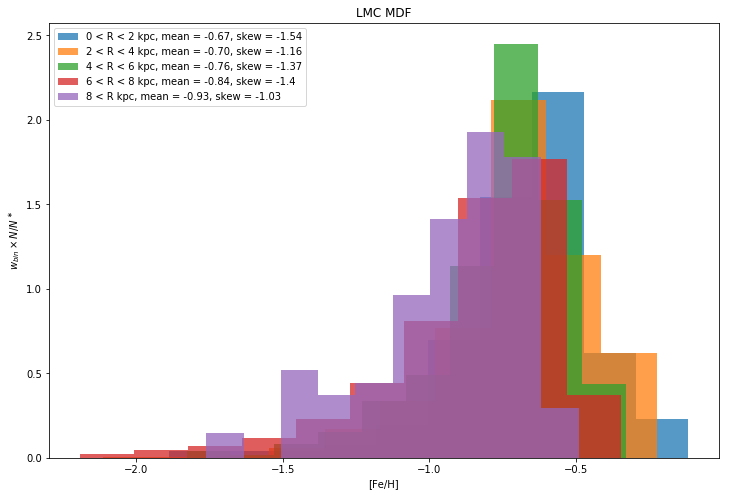

In [5]:
from scipy.stats import skew
rad02 = np.where(clndr16['LMCRAD']<2.0) 
rad24 = np.where((clndr16['LMCRAD']>2.0)&(clndr16['LMCRAD']<4.0))
rad46 = np.where((clndr16['LMCRAD']>4.0)&(clndr16['LMCRAD']<6.0))
rad68 = np.where((clndr16['LMCRAD']>6.0)&(clndr16['LMCRAD']<8.0))
rad8p = np.where(clndr16['LMCRAD']>8.0)

radbins = [rad02,rad24,rad46,rad68,rad8p]
means = []
skews = []
for i in radbins:
    means.append(np.mean(clndr16['FE_H'][i]))
    skews.append(skew(clndr16['FE_H'][i]))
    
means = np.around(means,decimals=2)
skews = np.around(skews,decimals=2)
# print(skews)

plt.figure(figsize=[12,8])
plt.hist(clndr16['FE_H'][rad02],density=1.0,alpha=0.75,stacked=True,\
         label='0 < R < 2 kpc, mean = -0.67, skew = {}'.format(skews[0]))
plt.hist(clndr16['FE_H'][rad24],density=1.0,alpha=0.75,stacked=True,\
         label='2 < R < 4 kpc, mean = -0.70, skew = {}'.format(skews[1]))
plt.hist(clndr16['FE_H'][rad46],density=1.0,alpha=0.75,stacked=True,\
         label='4 < R < 6 kpc, mean = -0.76, skew = {}'.format(skews[2]))
plt.hist(clndr16['FE_H'][rad68],density=1.0,alpha=0.75,stacked=True,\
         label='6 < R < 8 kpc, mean = -0.84, skew = {}'.format(skews[3]))
plt.hist(clndr16['FE_H'][rad8p],density=1.0,alpha=0.75,stacked=True,\
         label='8 < R kpc, mean = -0.93, skew = {}'.format(skews[4]))
plt.legend(loc='upper left')
plt.ylabel(r'$w_{bin} \times N/N^\ast}$')
plt.xlabel(r'[Fe/H]')
plt.title(r'LMC MDF')
plt.show()

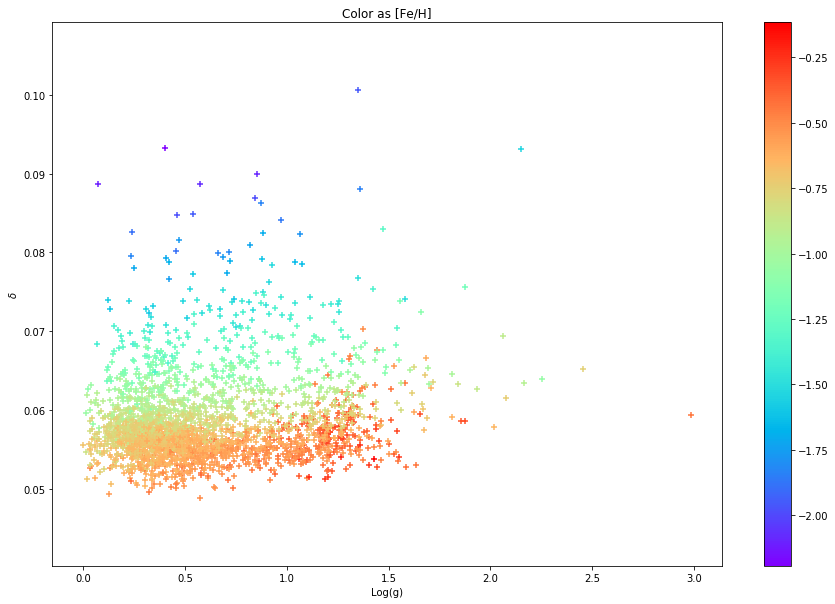

In [6]:
####################################
### Log(g) Uncertainty vs Log(g) ###
####################################

plt.figure(figsize=[15,10])
plt.scatter(clndr16['LOGG'],clndr16['LOGG_ERR'],marker='+',c=clndr16['FE_H'],cmap='rainbow')
# plt.xlim(0.0,0.5)
plt.xlabel(r'Log(g)')
plt.ylabel(r'$\delta$')
plt.colorbar()
plt.title(r'Color as [Fe/H]')
plt.show()


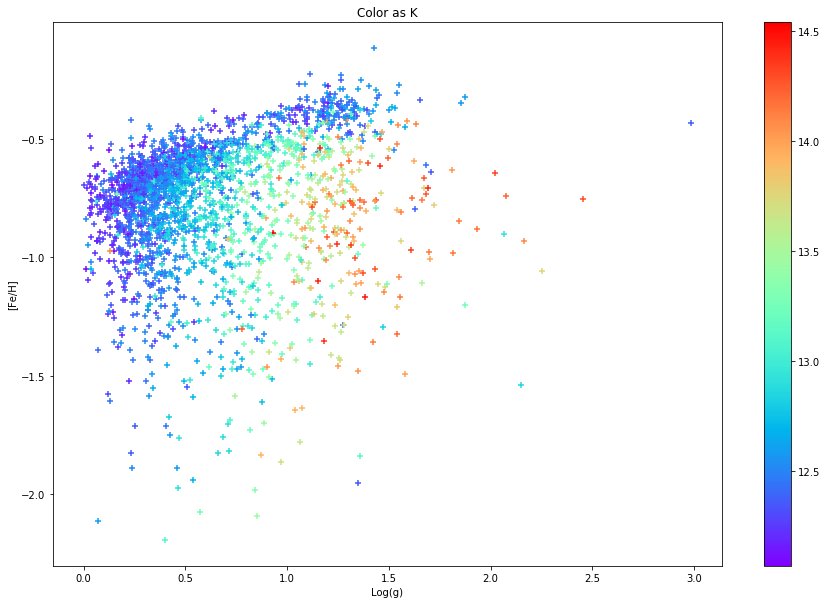

In [7]:
###########
### R13 ###
###########

plt.figure(figsize=[15,10])
plt.scatter(clndr16['LOGG'],clndr16['FE_H'],marker='+',c=clndr16['K'],cmap='rainbow')
# plt.xlim(0.0,0.5)
plt.xlabel(r'Log(g)')
plt.ylabel(r'[Fe/H]')
plt.colorbar()
plt.title(r'Color as K')
plt.show()

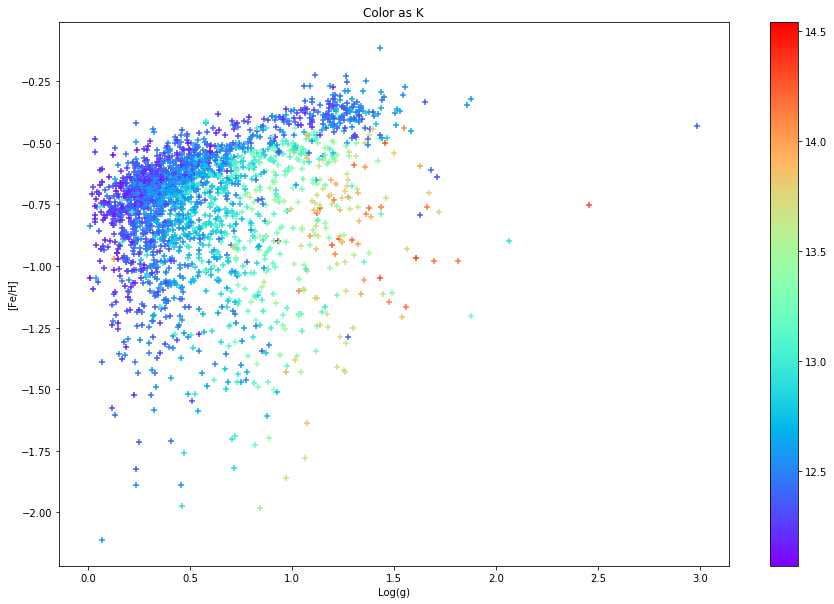

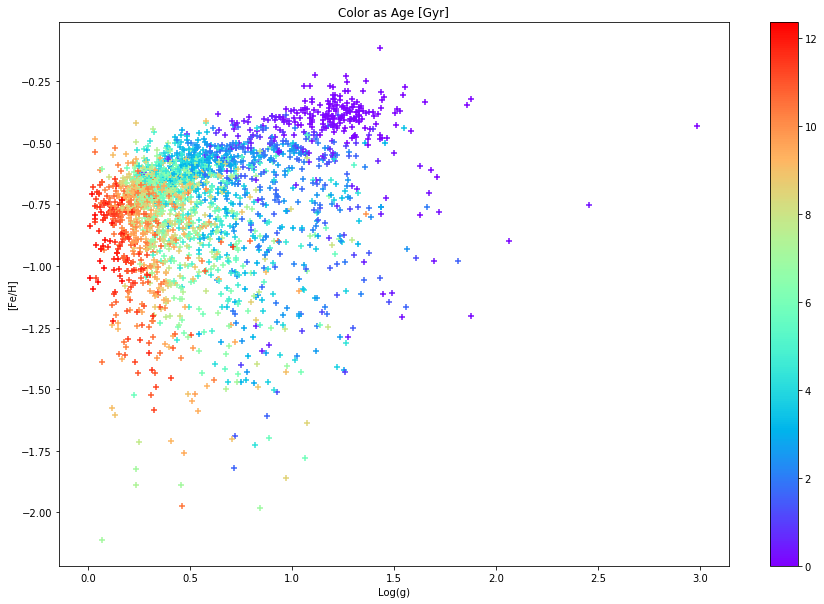

In [8]:
####################
### Diane's Ages ###
####################

plt.figure(figsize=[15,10])
plt.scatter(clndr16['LOGG'][y_ind],clndr16['FE_H'][y_ind],marker='+',c=clndr16['K'][y_ind],cmap='rainbow')
# plt.xlim(0.0,0.5)
plt.xlabel(r'Log(g)')
plt.ylabel(r'[Fe/H]')
plt.colorbar()
plt.title(r'Color as K')
plt.show()

plt.figure(figsize=[15,10])
plt.scatter(clndr16['LOGG'][y_ind],clndr16['FE_H'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='rainbow')
# plt.xlim(0.0,0.5)
plt.xlabel(r'Log(g)')
plt.ylabel(r'[Fe/H]')
plt.colorbar()
plt.title(r'Color as Age [Gyr]')
plt.show()

In [9]:
###################################
### Original Model with Gravity ###
###################################

def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,\
       0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

In [39]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
factsCN = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    factsCN.append(numerCN/denomCN)
factsCN = factsCN[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

uncteff = []
for i in range(len(clndr16)):
    uncteff.append(clndr16['FPARAM'][i][0])

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
testparage = parsec_age(np.log10(uncteff),corabsK,clndr16['M_H']+metscorr,clndr16['LOGG'])

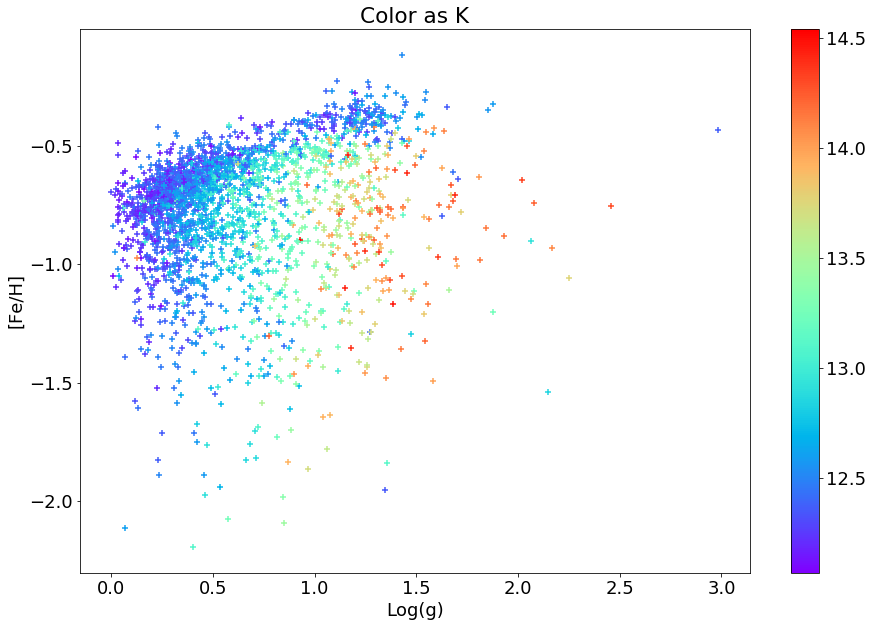

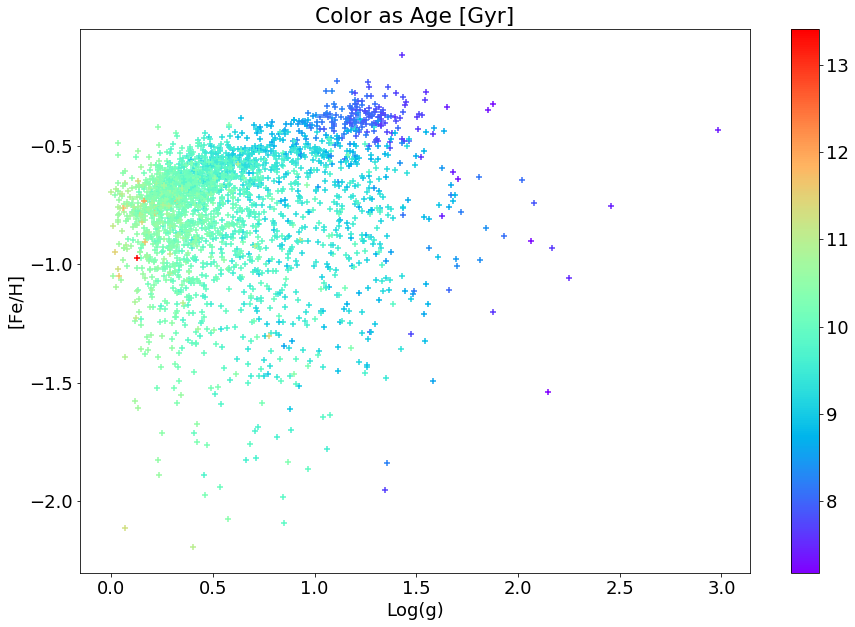

In [40]:
plt.figure(figsize=[15,10])
plt.scatter(clndr16['LOGG'],clndr16['FE_H'],marker='+',c=clndr16['K'],cmap='rainbow')
# plt.xlim(0.0,0.5)
plt.xlabel(r'Log(g)')
plt.ylabel(r'[Fe/H]')
plt.colorbar()
plt.title(r'Color as K')
plt.show()

plt.figure(figsize=[15,10])
plt.scatter(clndr16['LOGG'],clndr16['FE_H'],marker='+',c=testparage,cmap='rainbow')
# plt.xlim(0.0,0.5)
plt.xlabel(r'Log(g)')
plt.ylabel(r'[Fe/H]')
plt.colorbar()
plt.title(r'Color as Age [Gyr]')
plt.show()

In [41]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [42]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

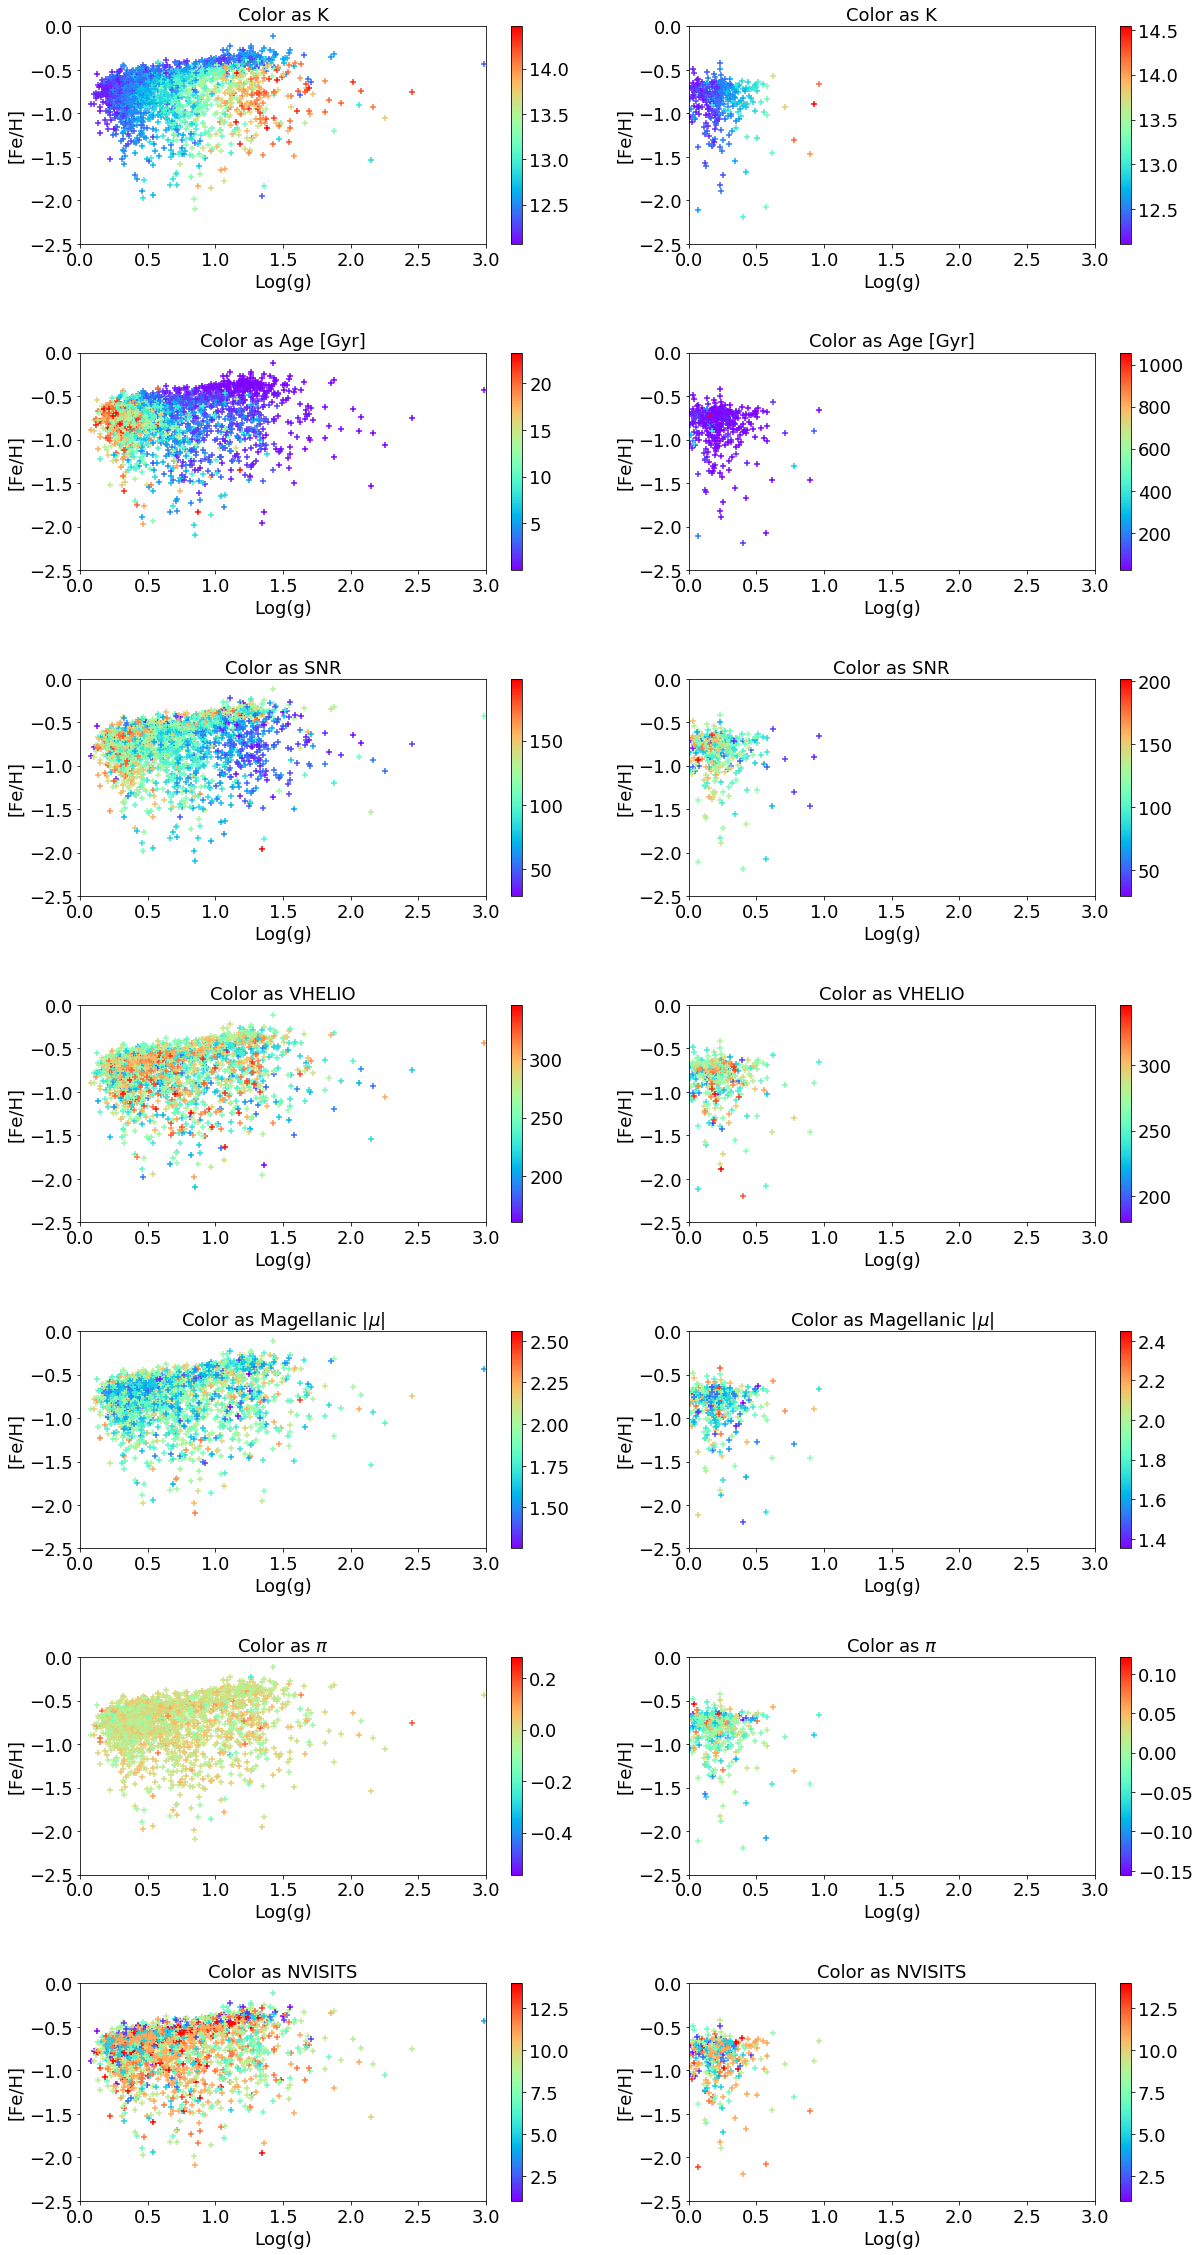

In [53]:
senex = np.where((testparage>np.log10(ageU)+max(devs))&(clndr16['APOGEE_ID']!='2M04184533-6818382')) \
#'2M04184533-6818382'
iuvenis = np.where((testparage<np.log10(ageU)+max(devs)))

gravs = [clndr16[iuvenis]['LOGG'],clndr16[senex]['LOGG']]
mets = [clndr16[iuvenis]['FE_H'],clndr16[senex]['FE_H']]
colors = [clndr16['K'],10**testparage/10**9,clndr16['SNR'],clndr16['VHELIO_AVG'],\
          np.sqrt(clndr16['GAIA_PMMB']**2+clndr16['GAIA_PMML']**2),clndr16['GAIA_PARALLAX'],clndr16['NVISITS']]

f, ax = plt.subplots(7,2, facecolor='w',figsize=(20,40))
p = ax[0,0].scatter(gravs[0],mets[0],marker='+',c=colors[0][iuvenis],cmap='rainbow')
ax[0,0].set_xlim(0.0,3.0)
ax[0,0].set_ylim(-2.5,0.0)
ax[0,0].set_title('Color as K',fontsize=18)
ax[0,0].set_xlabel('Log(g)')
ax[0,0].set_ylabel('[Fe/H]')
q = ax[0,1].scatter(gravs[1],mets[1],marker='+',c=colors[0][senex],cmap='rainbow')
ax[0,1].set_xlim(0.0,3.0)
ax[0,1].set_ylim(-2.5,0.0)
ax[0,1].set_title('Color as K',fontsize=18)
ax[0,1].set_xlabel('Log(g)')
ax[0,1].set_ylabel('[Fe/H]')
r = ax[1,0].scatter(gravs[0],mets[0],marker='+',c=colors[1][iuvenis],cmap='rainbow')
ax[1,0].set_xlim(0.0,3.0)
ax[1,0].set_ylim(-2.5,0.0)
ax[1,0].set_title('Color as Age [Gyr]',fontsize=18)
ax[1,0].set_xlabel('Log(g)')
ax[1,0].set_ylabel('[Fe/H]')
s = ax[1,1].scatter(gravs[1],mets[1],marker='+',c=colors[1][senex],cmap='rainbow')
ax[1,1].set_xlim(0.0,3.0)
ax[1,1].set_ylim(-2.5,0.0)
ax[1,1].set_title('Color as Age [Gyr]',fontsize=18)
ax[1,1].set_xlabel('Log(g)')
ax[1,1].set_ylabel('[Fe/H]')
t = ax[2,0].scatter(gravs[0],mets[0],marker='+',c=colors[2][iuvenis],cmap='rainbow')
ax[2,0].set_xlim(0.0,3.0)
ax[2,0].set_ylim(-2.5,0.0)
ax[2,0].set_title('Color as SNR',fontsize=18)
ax[2,0].set_xlabel('Log(g)')
ax[2,0].set_ylabel('[Fe/H]')
u = ax[2,1].scatter(gravs[1],mets[1],marker='+',c=colors[2][senex],cmap='rainbow')
ax[2,1].set_xlim(0.0,3.0)
ax[2,1].set_ylim(-2.5,0.0)
ax[2,1].set_title('Color as SNR',fontsize=18)
ax[2,1].set_xlabel('Log(g)')
ax[2,1].set_ylabel('[Fe/H]')
v = ax[3,0].scatter(gravs[0],mets[0],marker='+',c=colors[3][iuvenis],cmap='rainbow')
ax[3,0].set_xlim(0.0,3.0)
ax[3,0].set_ylim(-2.5,0.0)
ax[3,0].set_title('Color as VHELIO',fontsize=18)
ax[3,0].set_xlabel('Log(g)')
ax[3,0].set_ylabel('[Fe/H]')
w = ax[3,1].scatter(gravs[1],mets[1],marker='+',c=colors[3][senex],cmap='rainbow')
ax[3,1].set_xlim(0.0,3.0)
ax[3,1].set_ylim(-2.5,0.0)
ax[3,1].set_title('Color as VHELIO',fontsize=18)
ax[3,1].set_xlabel('Log(g)')
ax[3,1].set_ylabel('[Fe/H]')
x = ax[4,0].scatter(gravs[0],mets[0],marker='+',c=colors[4][iuvenis],cmap='rainbow')
ax[4,0].set_xlim(0.0,3.0)
ax[4,0].set_ylim(-2.5,0.0)
ax[4,0].set_title('Color as Magellanic |$\mu$|',fontsize=18)
ax[4,0].set_xlabel('Log(g)')
ax[4,0].set_ylabel('[Fe/H]')
y = ax[4,1].scatter(gravs[1],mets[1],marker='+',c=colors[4][senex],cmap='rainbow')
ax[4,1].set_xlim(0.0,3.0)
ax[4,1].set_ylim(-2.5,0.0)
ax[4,1].set_title('Color as Magellanic |$\mu$|',fontsize=18)
ax[4,1].set_xlabel('Log(g)')
ax[4,1].set_ylabel('[Fe/H]')
z = ax[5,0].scatter(gravs[0],mets[0],marker='+',c=colors[5][iuvenis],cmap='rainbow')
ax[5,0].set_xlim(0.0,3.0)
ax[5,0].set_ylim(-2.5,0.0)
ax[5,0].set_title('Color as $\pi$',fontsize=18)
ax[5,0].set_xlabel('Log(g)')
ax[5,0].set_ylabel('[Fe/H]')
a = ax[5,1].scatter(gravs[1],mets[1],marker='+',c=colors[5][senex],cmap='rainbow')
ax[5,1].set_xlim(0.0,3.0)
ax[5,1].set_ylim(-2.5,0.0)
ax[5,1].set_title('Color as $\pi$',fontsize=18)
ax[5,1].set_xlabel('Log(g)')
ax[5,1].set_ylabel('[Fe/H]')

b = ax[6,0].scatter(gravs[0],mets[0],marker='+',c=colors[6][iuvenis],cmap='rainbow')
ax[6,0].set_xlim(0.0,3.0)
ax[6,0].set_ylim(-2.5,0.0)
ax[6,0].set_title('Color as NVISITS',fontsize=18)
ax[6,0].set_xlabel('Log(g)')
ax[6,0].set_ylabel('[Fe/H]')
c = ax[6,1].scatter(gravs[1],mets[1],marker='+',c=colors[6][senex],cmap='rainbow')
ax[6,1].set_xlim(0.0,3.0)
ax[6,1].set_ylim(-2.5,0.0)
ax[6,1].set_title('Color as NVISITS',fontsize=18)
ax[6,1].set_xlabel('Log(g)')
ax[6,1].set_ylabel('[Fe/H]')

f.colorbar(p,ax=ax[0,0])
f.colorbar(q,ax=ax[0,1])
f.colorbar(r,ax=ax[1,0])
f.colorbar(s,ax=ax[1,1])
f.colorbar(t,ax=ax[2,0])
f.colorbar(u,ax=ax[2,1])
f.colorbar(v,ax=ax[3,0])
f.colorbar(w,ax=ax[3,1])
f.colorbar(x,ax=ax[4,0])
f.colorbar(y,ax=ax[4,1])
f.colorbar(z,ax=ax[5,0])
f.colorbar(a,ax=ax[5,1])
f.colorbar(b,ax=ax[6,0])
f.colorbar(c,ax=ax[6,1])

f.subplots_adjust(hspace=0.5)
f.savefig('oldnew1.jpg',bbox_inches='tight')
f.show()

# plt.figure(figsize=[6,5])
# plt.hist(colors[1][senex],bins=10)
# plt.axvline(10**np.log10(ageU)/10**9,linestyle='dashed',c='k')
# plt.axvline(10**(np.log10(ageU)+max(devs))/10**9,linestyle='dashed',c='r')
# plt.title('Ages Histogram')
# plt.ylabel('Count')
# plt.xlabel('Ages [Gyr]')
# #plt.xlim(0,10**(np.log10(ageU)+max(devs))/10**9+2.0)
# plt.show()

#print('Number of Outliers: ',len(np.squeeze(cut))-len(np.squeeze(cutage)))

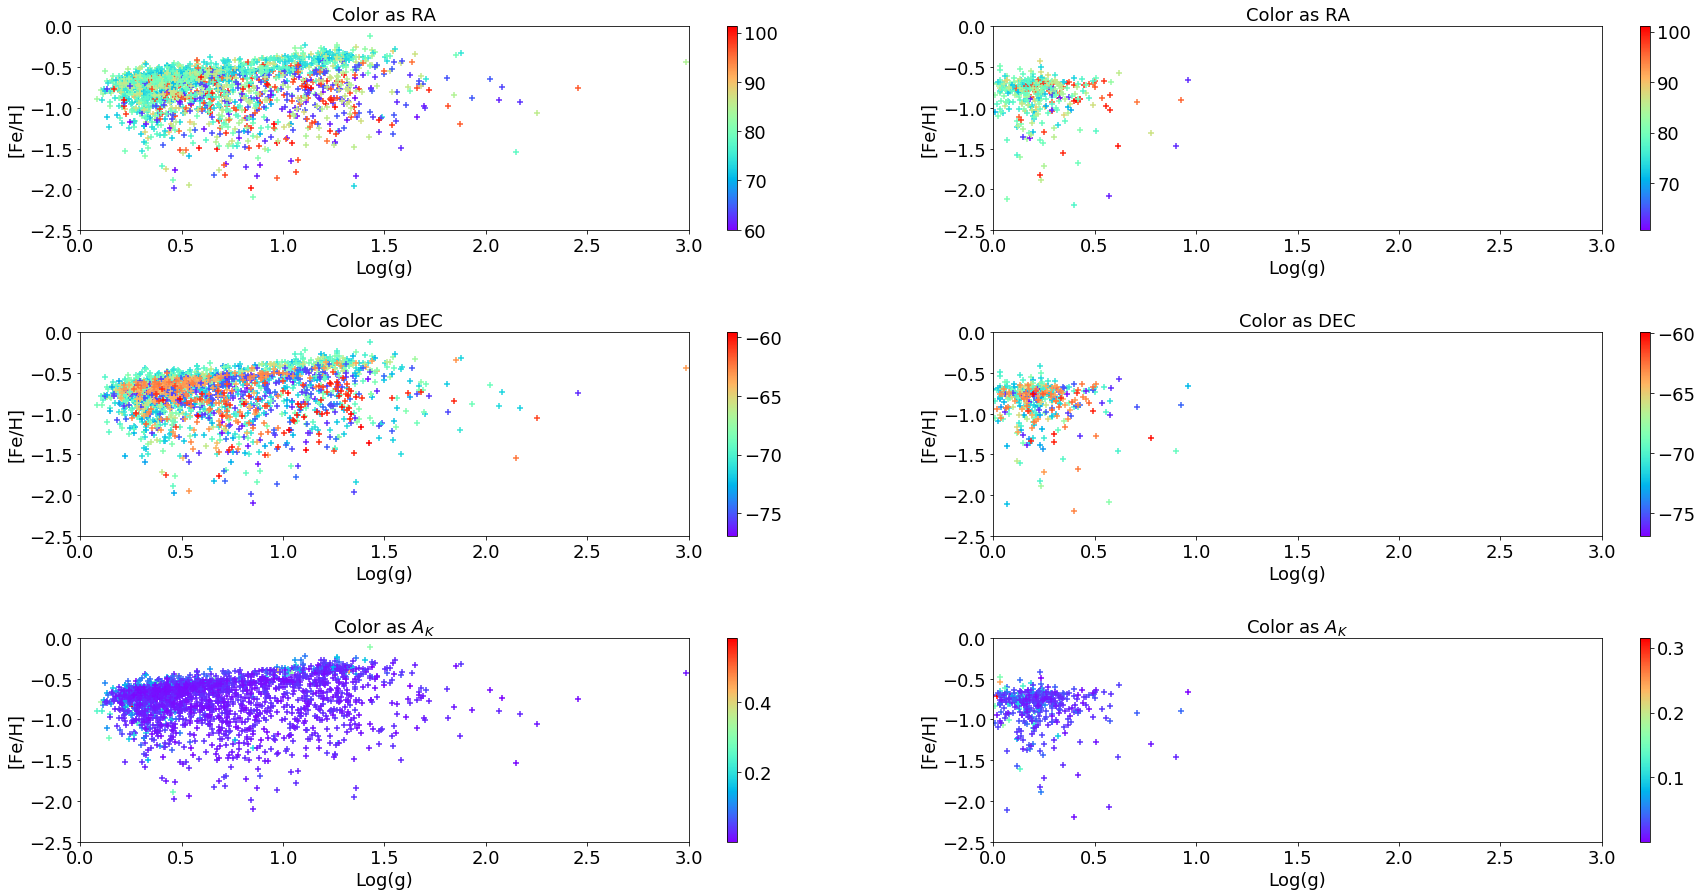

In [54]:
f, ax = plt.subplots(3,2, facecolor='w',figsize=(30,15))
p = ax[0,0].scatter(gravs[0],mets[0],marker='+',c=clndr16['RA'][iuvenis],cmap='rainbow')
ax[0,0].set_xlim(0.0,3.0)
ax[0,0].set_ylim(-2.5,0.0)
ax[0,0].set_title('Color as RA',fontsize=18)
ax[0,0].set_xlabel('Log(g)')
ax[0,0].set_ylabel('[Fe/H]')
q = ax[0,1].scatter(gravs[1],mets[1],marker='+',c=clndr16['RA'][senex],cmap='rainbow')
ax[0,1].set_xlim(0.0,3.0)
ax[0,1].set_ylim(-2.5,0.0)
ax[0,1].set_title('Color as RA',fontsize=18)
ax[0,1].set_xlabel('Log(g)')
ax[0,1].set_ylabel('[Fe/H]')
r = ax[1,0].scatter(gravs[0],mets[0],marker='+',c=clndr16['DEC'][iuvenis],cmap='rainbow')
ax[1,0].set_xlim(0.0,3.0)
ax[1,0].set_ylim(-2.5,0.0)
ax[1,0].set_title('Color as DEC',fontsize=18)
ax[1,0].set_xlabel('Log(g)')
ax[1,0].set_ylabel('[Fe/H]')
s = ax[1,1].scatter(gravs[1],mets[1],marker='+',c=clndr16['DEC'][senex],cmap='rainbow')
ax[1,1].set_xlim(0.0,3.0)
ax[1,1].set_ylim(-2.5,0.0)
ax[1,1].set_title('Color as DEC',fontsize=18)
ax[1,1].set_xlabel('Log(g)')
ax[1,1].set_ylabel('[Fe/H]')

t = ax[2,0].scatter(gravs[0],mets[0],marker='+',c=clndr16['AK_TARG'][iuvenis],cmap='rainbow')
ax[2,0].set_xlim(0.0,3.0)
ax[2,0].set_ylim(-2.5,0.0)
ax[2,0].set_title('Color as $A_{K}$',fontsize=18)
ax[2,0].set_xlabel('Log(g)')
ax[2,0].set_ylabel('[Fe/H]')
u = ax[2,1].scatter(gravs[1],mets[1],marker='+',c=clndr16['AK_TARG'][senex],cmap='rainbow')
ax[2,1].set_xlim(0.0,3.0)
ax[2,1].set_ylim(-2.5,0.0)
ax[2,1].set_title('Color as $A_K$',fontsize=18)
ax[2,1].set_xlabel('Log(g)')
ax[2,1].set_ylabel('[Fe/H]')

f.colorbar(p,ax=ax[0,0])
f.colorbar(q,ax=ax[0,1])
f.colorbar(r,ax=ax[1,0])
f.colorbar(s,ax=ax[1,1])
f.colorbar(t,ax=ax[2,0])
f.colorbar(u,ax=ax[2,1])

f.subplots_adjust(hspace=0.5)
plt.savefig('oldnew2.jpg',bbox_inches='tight')
f.show()

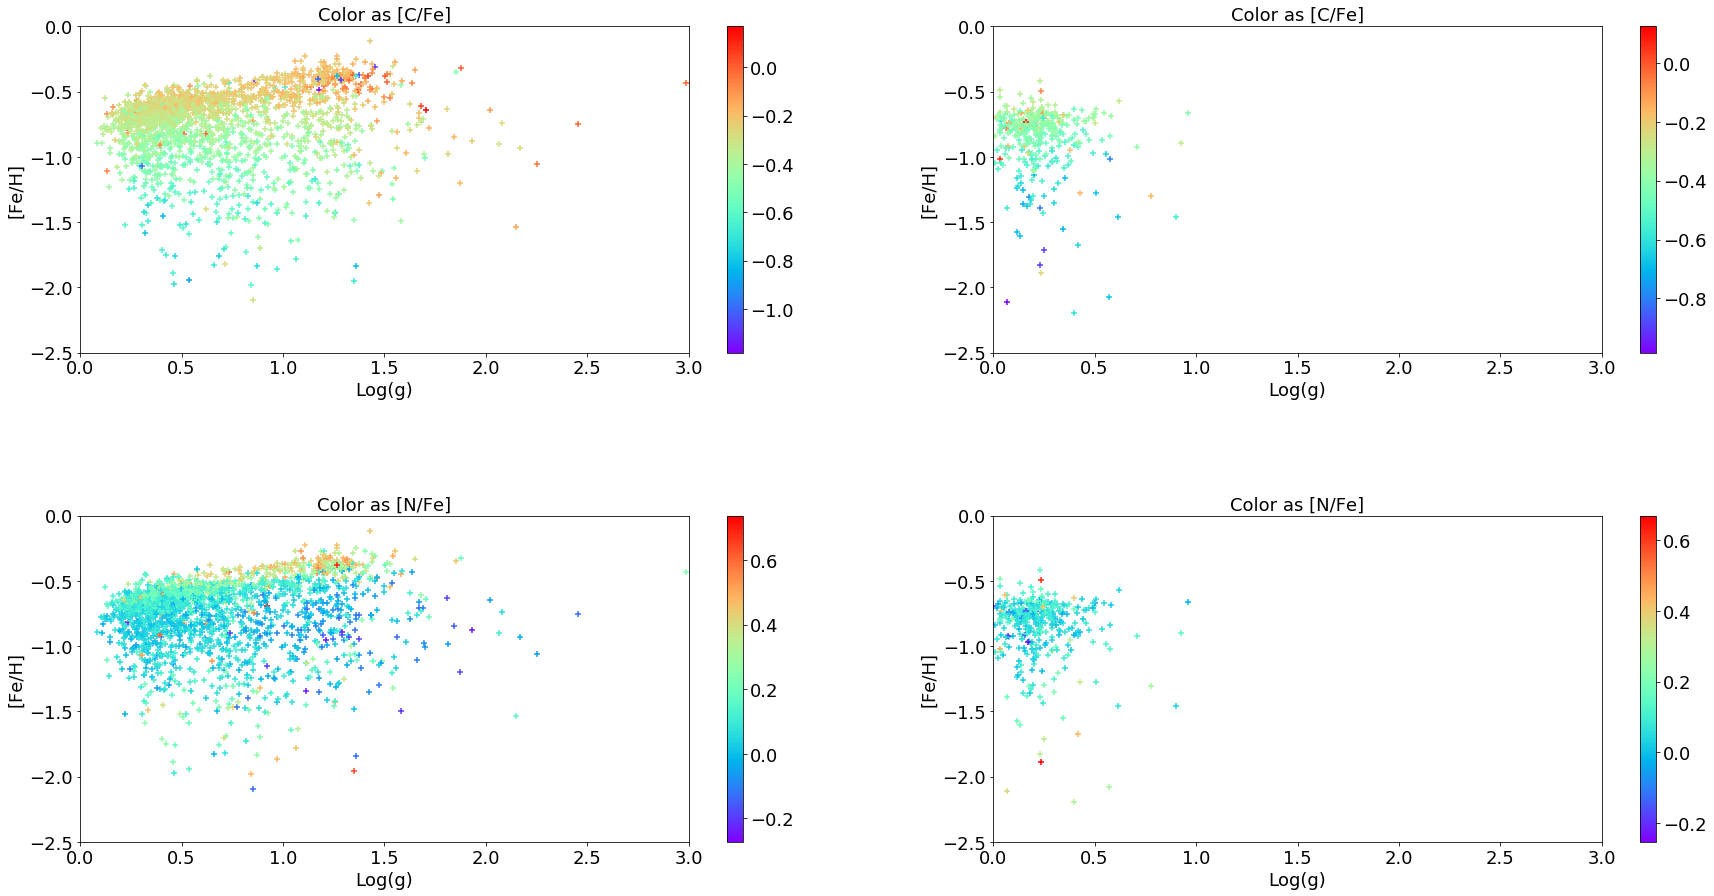

In [55]:
f, ax = plt.subplots(2,2, facecolor='w',figsize=(30,15))
p = ax[0,0].scatter(clndr16['LOGG'][iuvenis],clndr16['FE_H'][iuvenis],marker='+',c=clndr16['C_FE'][iuvenis],cmap='rainbow')
ax[0,0].set_xlim(0.0,3.0)
ax[0,0].set_ylim(-2.5,0.0)
ax[0,0].set_title('Color as [C/Fe]',fontsize=18)
ax[0,0].set_xlabel('Log(g)')
ax[0,0].set_ylabel('[Fe/H]')
q = ax[0,1].scatter(clndr16['LOGG'][senex],clndr16['FE_H'][senex],marker='+',c=clndr16['C_FE'][senex],cmap='rainbow')
ax[0,1].set_xlim(0.0,3.0)
ax[0,1].set_ylim(-2.5,0.0)
ax[0,1].set_title('Color as [C/Fe]',fontsize=18)
ax[0,1].set_xlabel('Log(g)')
ax[0,1].set_ylabel('[Fe/H]')
r = ax[1,0].scatter(clndr16['LOGG'][iuvenis],clndr16['FE_H'][iuvenis],marker='+',c=clndr16['N_FE'][iuvenis],cmap='rainbow')
ax[1,0].set_xlim(0.0,3.0)
ax[1,0].set_ylim(-2.5,0.0)
ax[1,0].set_title('Color as [N/Fe]',fontsize=18)
ax[1,0].set_xlabel('Log(g)')
ax[1,0].set_ylabel('[Fe/H]')
s = ax[1,1].scatter(clndr16['LOGG'][senex],clndr16['FE_H'][senex],marker='+',c=clndr16['N_FE'][senex],cmap='rainbow')
ax[1,1].set_xlim(0.0,3.0)
ax[1,1].set_ylim(-2.5,0.0)
ax[1,1].set_title('Color as [N/Fe]',fontsize=18)
ax[1,1].set_xlabel('Log(g)')
ax[1,1].set_ylabel('[Fe/H]')

f.colorbar(p,ax=ax[0,0])
f.colorbar(q,ax=ax[0,1])
f.colorbar(r,ax=ax[1,0])
f.colorbar(s,ax=ax[1,1])

f.subplots_adjust(hspace=0.5)
plt.savefig('oldnew3.jpg',bbox_inches='tight')
# f.show()

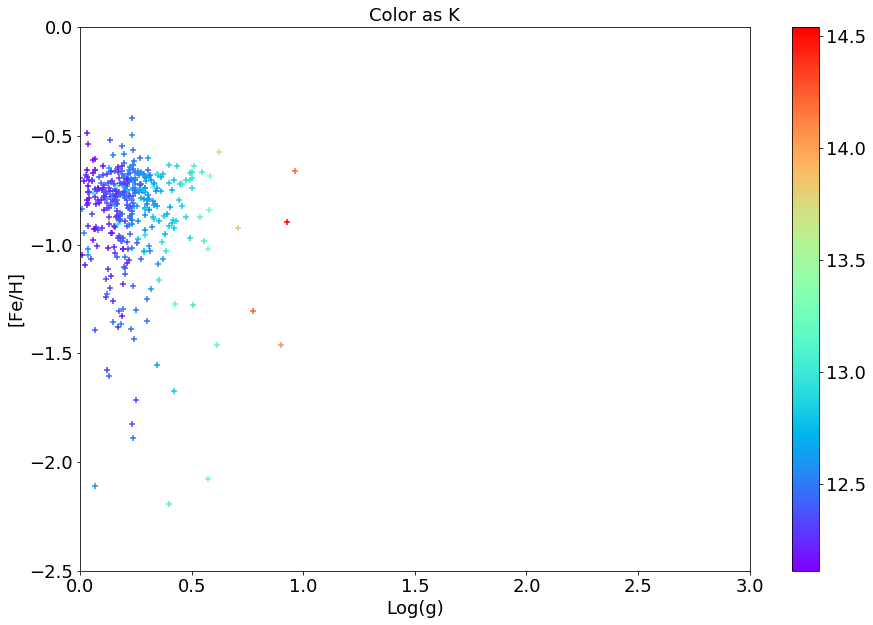

In [46]:
plt.figure(figsize=[15,10])
plt.scatter(gravs[1],mets[1],marker='+',c=colors[0][senex],cmap='rainbow')
plt.xlim(0.0,3.0)
plt.ylim(-2.5,0.0)
plt.title('Color as K',fontsize=18)
plt.xlabel('Log(g)')
plt.ylabel('[Fe/H]')
plt.colorbar()
plt.show()

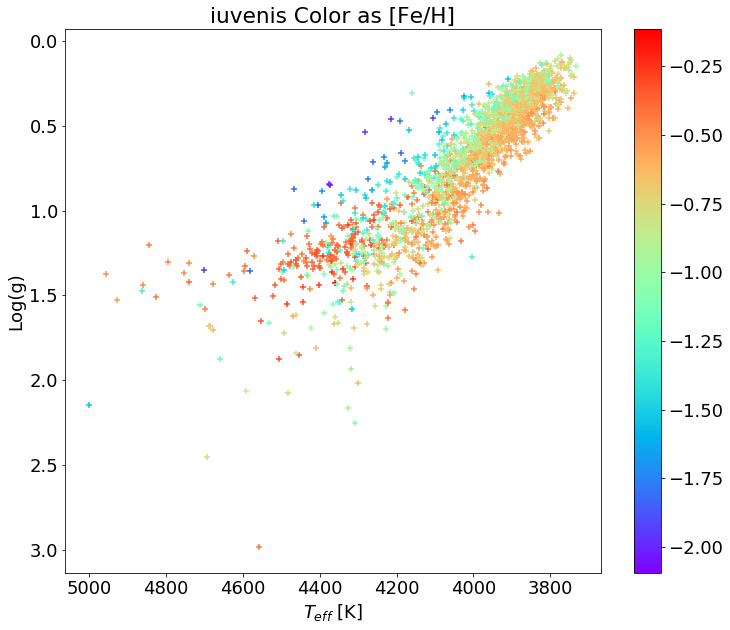

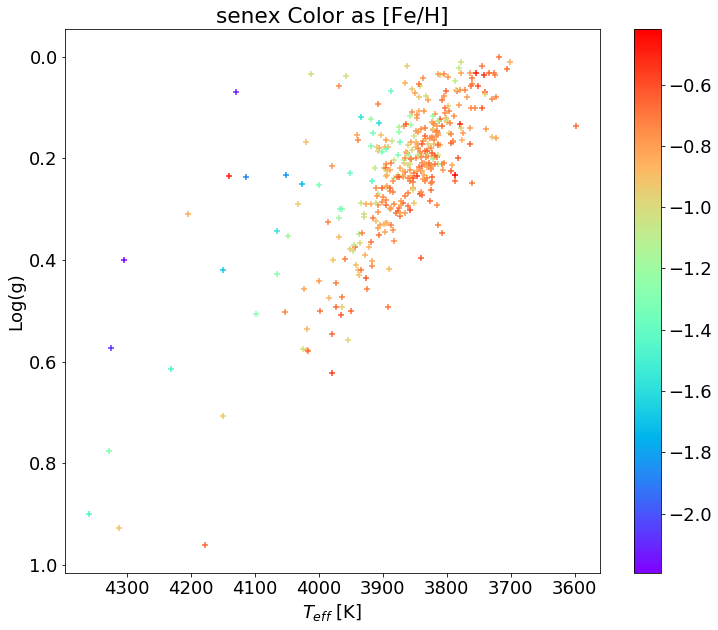

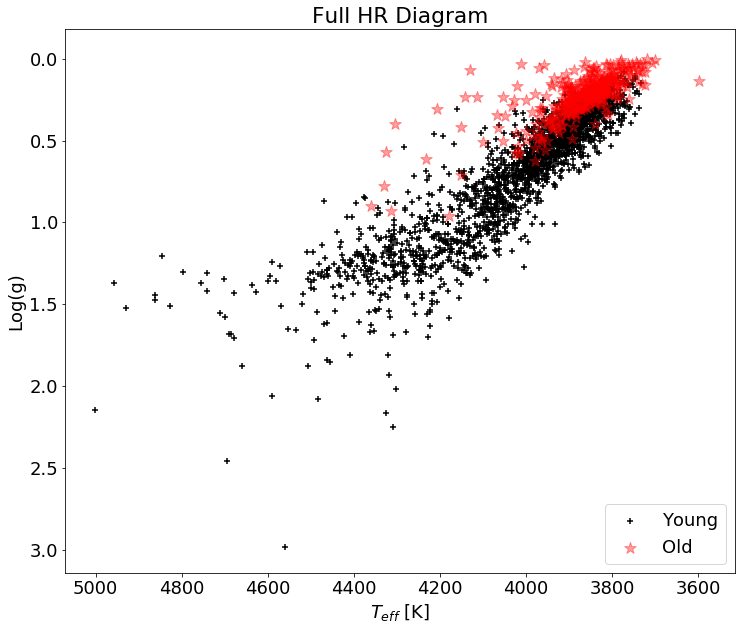

In [56]:
plt.figure(figsize=[12,10])
plt.scatter(clndr16['TEFF'][iuvenis],clndr16['LOGG'][iuvenis],c=clndr16['FE_H'][iuvenis],marker='+',cmap='rainbow')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar()
plt.title(r'iuvenis Color as [Fe/H]')
plt.xlabel(r'$T_{eff}$ [K]')
plt.ylabel(r'Log(g)')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['TEFF'][senex],clndr16['LOGG'][senex],c=clndr16['FE_H'][senex],marker='+',cmap='rainbow')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar()
plt.title(r'senex Color as [Fe/H]')
plt.xlabel(r'$T_{eff}$ [K]')
plt.ylabel(r'Log(g)')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['TEFF'][iuvenis],clndr16['LOGG'][iuvenis],c='k',marker='+',label='Young')
plt.scatter(clndr16['TEFF'][senex],clndr16['LOGG'][senex],c='r',marker='*',s=150,alpha=0.375,label='Old')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Full HR Diagram')
plt.xlabel(r'$T_{eff}$ [K]')
plt.ylabel(r'Log(g)')
plt.legend(loc='lower right')
plt.savefig('HR_oldyoungV2.pdf',bbox_inches='tight')
plt.show()

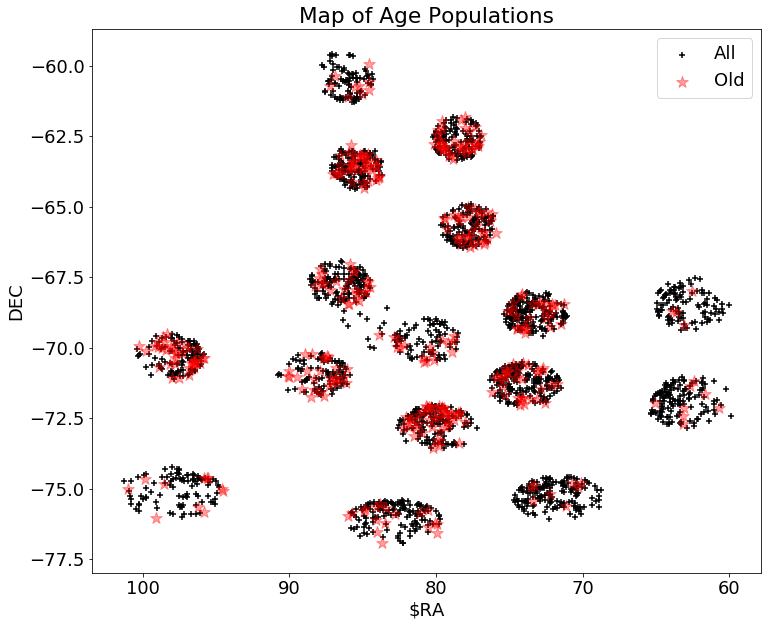

In [57]:
plt.figure(figsize=[12,10])
plt.scatter(clndr16['RA'][iuvenis],clndr16['DEC'][iuvenis],c='k',marker='+',label='All')
plt.scatter(clndr16['RA'][senex],clndr16['DEC'][senex],c='r',marker='*',s=150,alpha=0.375,label='Old')
plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
plt.title(r'Map of Age Populations')
plt.xlabel(r'$RA')
plt.ylabel(r'DEC')
plt.legend(loc='upper right')
plt.savefig('Pos_oldyoung.pdf',bbox_inches='tight')
plt.show()

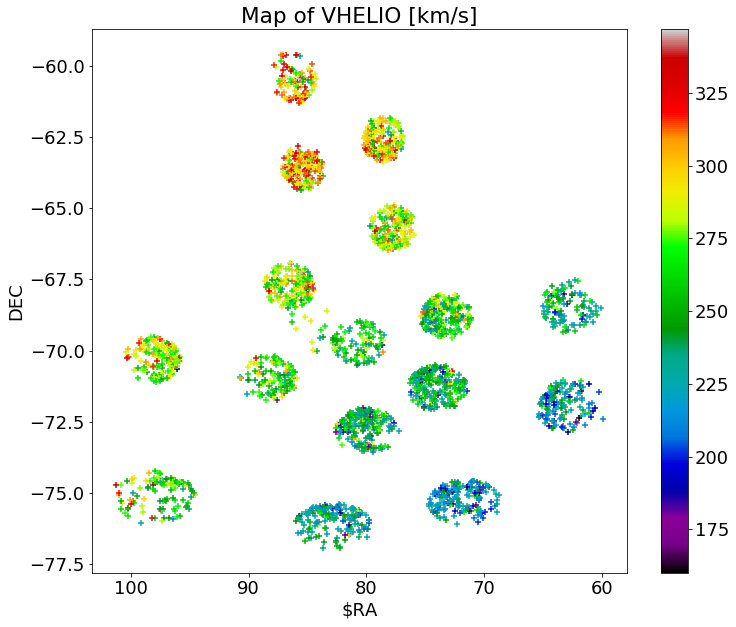

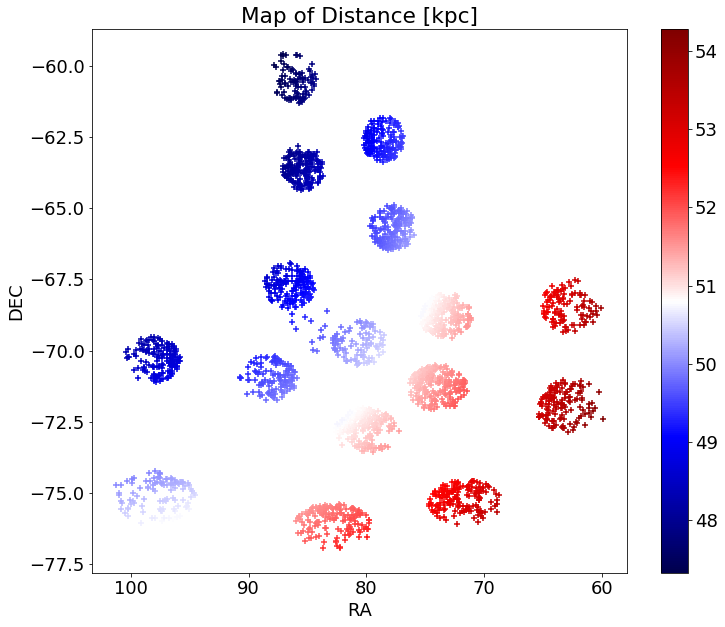

In [52]:
plt.figure(figsize=[12,10])
plt.scatter(clndr16['RA'],clndr16['DEC'],c=clndr16['VHELIO_AVG'],marker='+',cmap='nipy_spectral')
plt.gca().invert_xaxis()
plt.title(r'Map of VHELIO [km/s]')
plt.xlabel(r'$RA')
plt.ylabel(r'DEC')
# plt.legend(loc='upper right')
plt.colorbar()
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['RA'],clndr16['DEC'],c=stardist,marker='+',cmap='seismic')
plt.gca().invert_xaxis()
plt.title(r'Map of Distance [kpc]')
plt.xlabel(r'RA')
plt.ylabel(r'DEC')
# plt.legend(loc='upper right')
plt.colorbar()
plt.show()

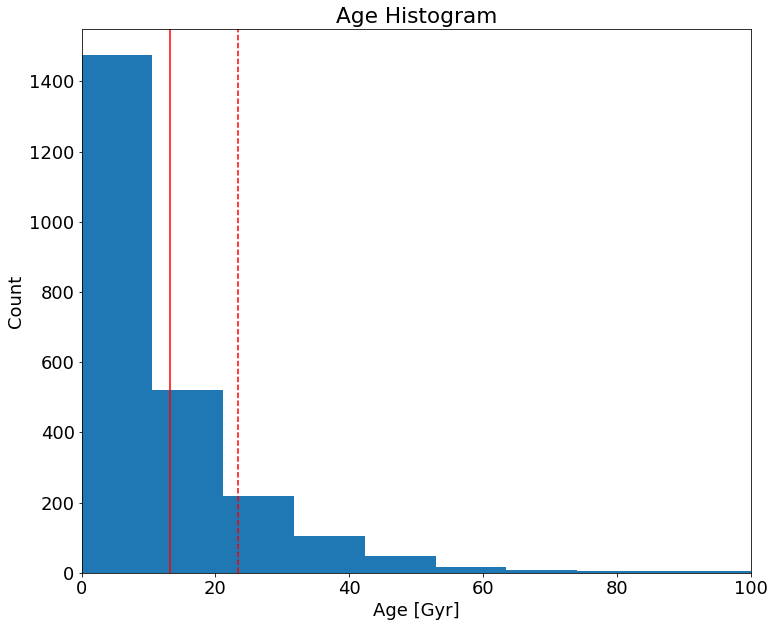

In [58]:
#####################
### Age Histogram ###
#####################

cut = np.where(testparage!=max(testparage))
#cutcut = np.where(testparage[cut]!=max(testparage[cut]))

# plt.figure(figsize=[12,10])
# plt.hist(10**testparage/10**9,bins=100)
# plt.axvline(10**np.log10(ageU)/10**9,c='k')
# plt.axvline(10**(np.log10(ageU)+max(devs))/10**9,c='r',linestyle='--')
# plt.title(r'Age Histogram')
# plt.xlabel(r'Age [Gyr]')
# plt.ylabel('Count')
# plt.show()

plt.figure(figsize=[12,10])
plt.hist(10**testparage[cut]/10**9,bins=100)
plt.axvline(10**np.log10(ageU)/10**9,c='r')
plt.axvline(10**(np.log10(ageU)+max(devs))/10**9,c='r',linestyle='--')
plt.title(r'Age Histogram')
plt.xlabel(r'Age [Gyr]')
plt.ylabel('Count')
plt.xlim(0,100)
plt.savefig('agehistogram',bbox_inches='tight')
plt.show()

In [23]:
10**(np.log10(ageU)+max(devs))/10**9

23.320456675433405

In [24]:
parsec.columns

<TableColumns names=('Zini','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

In [ ]:
#############################
### functions do not work ###
#############################

b1 = basti['KMAG']
b2 = basti['FEH']
b3 = basti['LOGG']
m1 = mist['2MASS_Ks']
m2 = mist['FeH']
m3 = mist['log_g']
a1 = parsec['Ksmag'] 
a2 = np.log10(parsec['Zini']/0.02)
a3 = parsec['logg']

import statsmodels.api as sm

modl = np.array([b1,b2]).T
modl = sm.add_constant(modl)
modl_model = sm.OLS(b3,modl).fit()
modl_predictions = modl_model.predict(modl)
modl_residual = modl_predictions - b3
modl_summary = modl_model.summary()
print(modl_summary)
print(np.asarray(modl_model.params))

modl = np.array([b1,b2]).T
modl = sm.add_constant(modl)
modl_model = sm.OLS(b3,modl).fit()
modl_predictions = modl_model.predict(modl)
modl_residual = modl_predictions - b3
modl_summary = modl_model.summary()
print(modl_summary)
print(np.asarray(modl_model.params))

modl = np.array([a1,a2]).T
modl = sm.add_constant(modl)
modl_model = sm.OLS(a3,modl).fit()
modl_predictions = modl_model.predict(modl)
modl_residual = modl_predictions - a3
modl_summary = modl_model.summary()
print(modl_summary)
print(np.asarray(modl_model.params))

In [329]:
#############################
### functions do not work ###
#############################

def bastigrav(x1,x2):
    p=[3.17991676,0.34064872,0.04537452]
    return p[0]+p[1]*x1+p[2]*x2

def mistgrav(x1,x2):
    p=[3.28181093,0.41453084,0.06399238]
    return p[0]+p[1]*x1+p[2]*x2

def parsecgrav(x1,x2):
    p=[3.15718497,0.39661444,0.01450273]
    return p[0]+p[1]*x1+p[2]*x2

In [330]:
#############################
### functions do not work ###
#############################

bgravs = bastigrav(corabsK,clndr16['FE_H'])
mgravs = mistgrav(corabsK,clndr16['FE_H'])
pgravs = parsecgrav(corabsK,clndr16['FE_H'])

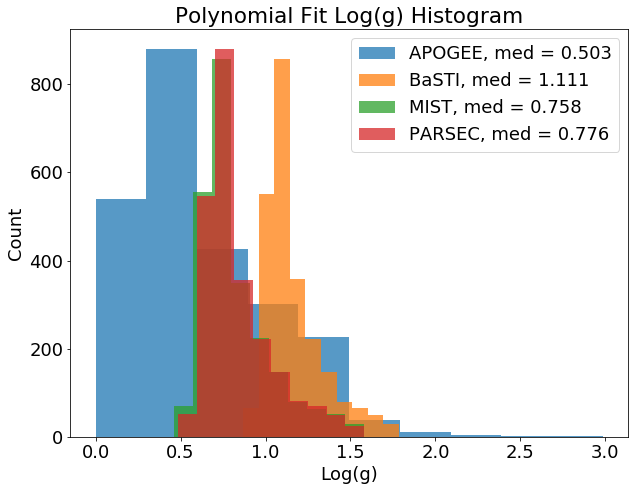

In [339]:
#############################
### functions do not work ###
#############################

medians = [str(round(np.median(clndr16['LOGG']),3)),round(np.median(bgravs),3),round(np.median(mgravs),3),\
           round(np.median(pgravs),3)]
plt.figure(figsize=[10,7.5])
plt.hist(clndr16['LOGG'],alpha=0.75,label='APOGEE, med = {}'.format(medians[0]))
plt.hist(bgravs,alpha=0.75,label='BaSTI, med = {}'.format(medians[1]))
plt.hist(mgravs,alpha=0.75,label='MIST, med = {}'.format(medians[2]))
plt.hist(pgravs,alpha=0.75,label='PARSEC, med = {}'.format(medians[3]))
plt.xlabel(r'Log(g)')
plt.ylabel(r'Count')
plt.title(r'Polynomial Fit Log(g) Histogram')
plt.legend()
plt.show()


In [90]:
clndr16.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '39A'
    name = 'ASPCAP_ID'; format = '56A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '105A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '18A'
    name

(array([ 681., 1011.,  354.,  187.,  102.,   56.,   21.,    6.,    4.,
           5.]),
 array([0.72394875, 0.94321465, 1.16248056, 1.38174647, 1.60101238,
        1.82027828, 2.03954419, 2.2588101 , 2.478076  , 2.69734191,
        2.91660782]),
 <a list of 10 Patch objects>)

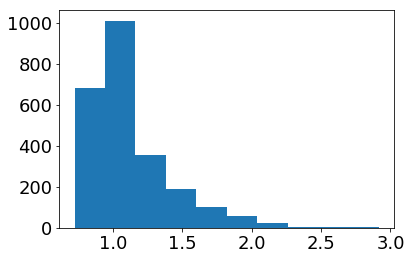

In [358]:
plt.hist(10**parfit(np.log10(clndr16['TEFF']),corabsK,clndr16['M_H']+metscorr,pgravs)/10**9)